# C3D-Siamese Network

In [18]:
"""
Created on Mon Jan 22 16:20:03 2018

@author: Wail
"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import matplotlib.pyplot as plt 
from random import randint
import pickle
import os.path
import time
from six.moves import xrange  # pylint: disable=redefined-builtin
import tensorflow as tf
#import input_data
#import c3d_model
import numpy as np
from IPython.display import Image
pickle_path_kth="data/kth_data.p"
pickle_path_Weizmann="data/Weizmann_test.p"

## Presenting C3D-siamese model

First, a siamese network is defined as follow:

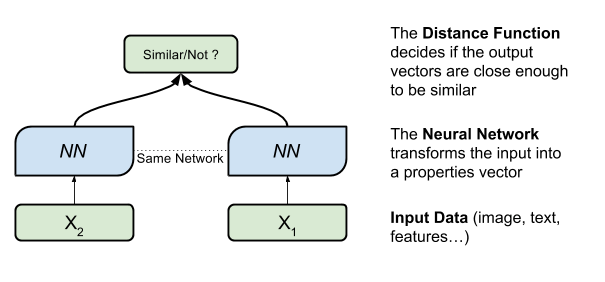

In [24]:
Image(filename='../img/siamese.png') 

C3D model is defined as follow:

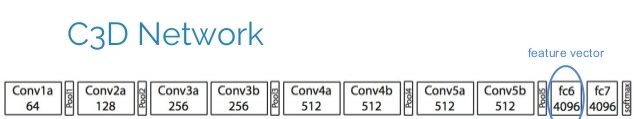

In [21]:
Image(filename='../img/c3d.jpg') 

## Purpose 

The purpose of the C3D-siamese model is to detect similarity between actions (specificaly imitation). In other words given these 4 videos:

 - swim_person1.avi and swim_person2.avi
 - boxing_person3.avi and boxing_person4.avi
 
We want our model to give us the following results:
 - C3D-siamese(swim_person1.avi,swim_person2.avi)=1 ---> similar
 - C3D-siamese(swim_person1.avi,boxing_person4.avi)=0  ----> not similar


## Model Architecture 

the C3D-siamese architecture is derived from the siamese one where:
- The inputs are videos decomposed into a series of frames (X1: video1, X2: video2)
- The Neural Network is a 3-Dimensional Convolutional Networks pre-trained on **sports1m** dataset and used for feature extraction. 
*for further details visit this link (http://vlg.cs.dartmouth.edu/c3d/)*
- For the distance function we took a different path. Knowing that NN(X1)==Y1 and NN(X2)==Y2 we defined our distance function (or vector difference) as Z=abs(Y1-Y2) where Z is still a vector whereas in the classical siamese architecture is z equal to (1 :similar or 0 :not-similar)
- Now we use Z as an input to another Neural network for binary classification similar/not-similar

### We train only this Network:

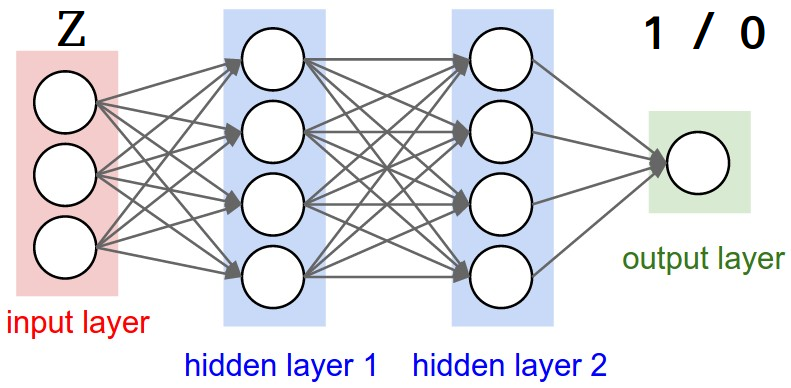

In [22]:
Image(filename='../img/nn.png') 

#  KTH and WEIZMANN Datasets

- **KTH is for training**
- **WEIZMANN is for testing**

### KTH description

1. Classes
 - Number of action classes = 6.
 - Classes/verbs: walking, jogging, running, boxing, hand waving, and hand clapping.
2. Videos
    - 600 videos.
    - Resolution = 160x120.
    - Black and white videos.
    - Static camera.
3. Properties
    - Homogeneous indoor/outdoor backgrounds.
    - Performed by 25 persons, 4 scenes, and 6 classes/verbs. 
4. Website for more infos (http://www.nada.kth.se/cvap/actions/)

### WEIZMANN description

1. Classes
    - Number of action classes = 10.
    - Verbs: walk, run, jump, gallop sideways, bend, one-hand wave, two-hands wave, jump in place, jumping jack, skip.
2. Videos
    - 90 videos.
    - Resolution = 180x144.
    - Static camera.
3. Properties
    - Homogeneous outdoor backgrounds.
    
    
    
    

## C3D features extraction

 **The features extraction procedure is overwhelming therefore it will be described in another notebook**
                        - Videos -----> fc6 features (4069 dimension vector)

### KTH features

In [3]:
### features are pickled for efficiency
kth_data = pickle.load( open( pickle_path_kth, "rb" ) )
print("Classes = ",kth_data['classes'])
print("KTH train data shape: ", kth_data['train_data'].shape)
print("KTH test data shape: ", kth_data['test_data'].shape)
print("KTH train labels between 0-6 : ", kth_data['train_labels'][:20])
print("KTH test labels between 0-6 : ", kth_data['test_labels'][:20])

Classes =  ['walking', 'jogging', 'running', 'boxing', 'handwaving', 'handclapping']
KTH train data shape:  (499, 4096)
KTH test data shape:  (101, 4096)
KTH train labels between 0-6 :  [1 0 1 1 0 5 2 0 0 0 0 1 3 3 0 3 1 3 5 4]
KTH test labels between 0-6 :  [2 4 2 0 3 1 1 1 1 0 3 4 0 3 3 3 4 0 2 3]


### WEIZMANN features

In [4]:
### features are pickled for efficiency, same as before except weizmann dataset is used for testing
Weizmann_test_data=pickle.load( open(pickle_path_Weizmann, "rb" ) )
print(Weizmann_test_data)

{'classes': ['run', 'walk', 'skip', 'jack', 'bend', 'wave', 'jump', 'side', 'pj'], 'test_labels': array([7, 4, 1, 7, 3, 7, 6, 3, 5, 8, 4, 0, 4, 2, 8, 7, 1, 4, 8, 2, 1, 5,
       1, 5, 5, 4, 5, 4, 5, 8, 8, 4, 3, 5, 5, 1, 6, 3, 6, 8, 8, 3, 7, 5,
       5, 7, 5, 3, 6, 2, 0, 0, 1, 5, 2, 2, 5, 1, 5, 2, 5, 5, 3, 4, 1, 3,
       1, 5, 6, 4, 0, 3, 8, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2]), 'test_data': array([[0.        , 0.        , 0.        , ..., 0.        , 0.6928104 ,
        0.        ],
       [0.        , 0.        , 0.17376561, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.75278556, 0.        , ..., 1.09073   , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.1108038 , 0.        ,
        0.        ],
       [0.        , 0.9212859 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.1273484 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        

# Implementation with Tensorflow

In [5]:
#### trainable variables
def _variable_on_cpu(name, shape, initializer,trainable):
  #with tf.device('/cpu:%d' % cpu_id):
  with tf.device('/gpu:0'):
    var = tf.get_variable(name, shape, initializer=initializer,trainable=trainable)
  return var

def _variable_with_weight_decay(name, shape, stddev, wd,trainable=False):
  var = _variable_on_cpu(name, shape, tf.truncated_normal_initializer(stddev=stddev),trainable=trainable)
  if wd is not None:
    weight_decay = tf.nn.l2_loss(var) * wd
    tf.add_to_collection('losses', weight_decay)
  return var

In [6]:
########## getting  KTH training  batchs ################################
def get_batch_train(batch_size,kth_data):
    train=kth_data["train_data"]
    train_label=kth_data["train_labels"]
    rand_indexes=[randint(0, train.shape[0]-1) for i in range(batch_size)]
    return train[rand_indexes],train_label[rand_indexes] 
########## getting WEIZMANN test data  #################
def get_all_test(kth_data):
    test=kth_data["test_data"]
    test_label=kth_data["test_labels"]
    rand_indexes=[randint(0, test.shape[0]-1) for i in range(test.shape[0])]
    return test[rand_indexes],test_label[rand_indexes]
    

### Training/Testing the Network 

In [7]:
def Siamese():
  _dropout=0.8  
  tf.reset_default_graph()
  ########### DATA KTH and WEIZMANN  
  kth_data = pickle.load( open( pickle_path_kth, "rb" ) )
  Weizmann_test_data=pickle.load( open(pickle_path_Weizmann, "rb" ) )
  ################ placeholders: Input data ######################  
  X_input = tf.placeholder(tf.float32, [None, 4096])
  Z_input = tf.placeholder(tf.float32, [None, 4096])
  Y = tf.placeholder(tf.float32, [None, 2])

  sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True))
 
#  ANN Variables

  W_1=_variable_with_weight_decay('W_1', [4096, 2000], 0.04, 0.005,trainable=True)
  b_1=_variable_with_weight_decay('b_1', [2000], 0.04, 0.0,trainable=True)
  
  W_2=_variable_with_weight_decay('W_2', [2000, 1000], 0.04, 0.005,trainable=True)
  b_2=_variable_with_weight_decay('b_2', [1000], 0.04, 0.0,trainable=True)
  
  W_3=_variable_with_weight_decay('W_3', [1000, 200], 0.04, 0.005,trainable=True)
  b_3=_variable_with_weight_decay('b_3', [200], 0.04, 0.0,trainable=True)
  
  
  W_4=_variable_with_weight_decay('W_4', [200, 2], 0.04, 0.005,trainable=True)
  b_4=_variable_with_weight_decay('b_4', [2], 0.04, 0.0,trainable=True)
 
  ### ANN operations ###
  
  l1=tf.add(tf.matmul(tf.abs(X_input-Z_input),W_1), b_1)   
  l1=tf.nn.relu(l1, 'relu11')
  l1=tf.nn.dropout(l1, _dropout)
  
  l2=tf.add(tf.matmul(l1,W_2), b_2)
  l2=tf.nn.relu(l2, 'relu22')
  l2=tf.nn.dropout(l2, _dropout)
  
  l3=tf.add(tf.matmul(l2,W_3), b_3)
  l3=tf.nn.relu(l3, 'relu33')
  l3=tf.nn.dropout(l3, _dropout)
  
  Siamese_output=tf.add(tf.matmul(l3,W_4), b_4)
  Siamese_output=tf.nn.relu(Siamese_output, 'relu44')

  loss_opp = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
             logits=Siamese_output, labels=Y))
  prediction = tf.nn.softmax(Siamese_output)
  
  # Evaluate model
  correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
  accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

  optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
  train_op = optimizer.minimize(loss_opp)
  init = tf.global_variables_initializer()
  
  sess.run(init)

  loss_list=[]
  acc_list=[]
  acc_test_list=[]
  acc_test_list_weizmann=[]
  
  for step in xrange(4000):
    # generate random batches for training  
    X,X_label=get_batch_train(kth_data=kth_data,batch_size=150)
    Z,Z_label=get_batch_train(kth_data=kth_data,batch_size=150)
    
    A=Z_label==X_label
    y=[[1,0] if a else [0,1] for a in A ] 
    
    ######## calculate batch loss #######################
    loss=sess.run([loss_opp,train_op],  feed_dict={X_input: X, Z_input: Z, Y:y})
    ####### calculate batch accuracy #####################
    acc=sess.run([accuracy],  feed_dict={X_input: X, Z_input: Z, Y:y})
    
    loss_list.append(loss[0]) 
    acc_list.append(acc[0])
    
    print("loss  "+str(loss[0])+"  accuracy "+ str(acc[0]))
 
    
  X,X_label=get_all_test(kth_data=kth_data)
  Z,Z_label=get_all_test(kth_data=kth_data)
  A=Z_label==X_label
  y=[[1,0] if a else [0,1] for a in A ] 
  print("####### accuracy score on Kth loading########### ")          
  for i in range(20):
      acc_test=sess.run([accuracy],   feed_dict={X_input: X, Z_input: Z, Y:y})
      acc_test_list.append(acc_test[0])
      
  X,X_label=get_all_test(kth_data=Weizmann_test_data)
  Z,Z_label=get_all_test(kth_data=Weizmann_test_data)
  A=Z_label==X_label
  y=[[1,0] if a else [0,1] for a in A ] 
  print("####### accuracy score on Weizmann loading########### ")          
  for i in range(20):
      acc_test=sess.run([accuracy],   feed_dict={X_input: X, Z_input: Z, Y:y})
      acc_test_list_weizmann.append(acc_test[0])   
      
      
  ##### save the model #######    
    #  saver = tf.train.Saver() 
    #  saver.save(sess, '/home/jan/Desktop/Tensorflow/kth_model/C3D')  
  print("done with Accuracy on Kth test data "+ str(np.mean(acc_test_list)))
  print("done with Accuracy on Weizmann data "+ str(np.mean(acc_test_list_weizmann)))
  
  
  return loss_list,acc_list,acc_test_list,acc_test_list_weizmann

In [8]:
################# Results #######################################
loss_list,acc_list,acc_test_list,acc_test_list_weizmann=Siamese()


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

loss  0.64776886  accuracy 0.79333335
loss  0.5894172  accuracy 0.7266667
loss  0.5082188  accuracy 0.8066667
loss  0.5663003  accuracy 0.76
loss  0.60314614  accuracy 0.76666665
loss  0.5451954  accuracy 0.78
loss  0.6262056  accuracy 0.75333333
loss  0.56454784  accuracy 0.7266667
loss  0.5889228  accuracy 0.73333335
loss  0.6063364  accuracy 0.7133333
loss  0.594445  accuracy 0.72
loss  0.6053417  accuracy 0.7266667
loss  0.60582393  accuracy 0.7133333
loss  0.60562986  accuracy 0.6933333
loss  0.58090943  accuracy 0.74
loss  0.51562023  accuracy 0.8
loss  0.6127381  accuracy 0.7266667
loss  0.5346875  accuracy 0.78
loss  0.6036238  accuracy 0.75333333
loss  0.5444365  accuracy 0.7733333
loss  0.5913814  accuracy 0.74
loss  0.6264137  accuracy 0.72
loss  0.5701354  accuracy 0.76666665
loss  0.5186

loss  0.54575384  accuracy 0.76
loss  0.51242775  accuracy 0.8
loss  0.6067869  accuracy 0.7133333
loss  0.48881602  accuracy 0.8
loss  0.4988435  accuracy 0.8
loss  0.63510114  accuracy 0.6933333
loss  0.636259  accuracy 0.67333335
loss  0.47499058  accuracy 0.8
loss  0.4990543  accuracy 0.8
loss  0.5524064  accuracy 0.76666665
loss  0.5706056  accuracy 0.74
loss  0.5563078  accuracy 0.76
loss  0.5736758  accuracy 0.74666667
loss  0.49952188  accuracy 0.8066667
loss  0.6122047  accuracy 0.7
loss  0.5840873  accuracy 0.73333335
loss  0.5352014  accuracy 0.76
loss  0.5396168  accuracy 0.75333333
loss  0.5134609  accuracy 0.8
loss  0.50839317  accuracy 0.79333335
loss  0.5333328  accuracy 0.76666665
loss  0.5195382  accuracy 0.78
loss  0.61935097  accuracy 0.6933333
loss  0.541075  accuracy 0.76666665
loss  0.5765218  accuracy 0.74666667
loss  0.5738634  accuracy 0.74666667
loss  0.59781796  accuracy 0.7266667
loss  0.5696443  accuracy 0.75333333
loss  0.5540684  accuracy 0.74666667
loss

loss  0.4373148  accuracy 0.8466667
loss  0.48095122  accuracy 0.82
loss  0.51267344  accuracy 0.7866667
loss  0.50667036  accuracy 0.7866667
loss  0.50469273  accuracy 0.7733333
loss  0.4668679  accuracy 0.82
loss  0.5549259  accuracy 0.76
loss  0.5163162  accuracy 0.7733333
loss  0.4942447  accuracy 0.7866667
loss  0.60551345  accuracy 0.73333335
loss  0.5635865  accuracy 0.75333333
loss  0.55486524  accuracy 0.73333335
loss  0.54588574  accuracy 0.74666667
loss  0.54173803  accuracy 0.7733333
loss  0.56661826  accuracy 0.74666667
loss  0.51748127  accuracy 0.76666665
loss  0.5562928  accuracy 0.76666665
loss  0.49778962  accuracy 0.7866667
loss  0.5869456  accuracy 0.73333335
loss  0.5255897  accuracy 0.74666667
loss  0.62093914  accuracy 0.72
loss  0.6079871  accuracy 0.7266667
loss  0.5697391  accuracy 0.7266667
loss  0.6374496  accuracy 0.68
loss  0.5253404  accuracy 0.7733333
loss  0.5286466  accuracy 0.78
loss  0.51988685  accuracy 0.79333335
loss  0.54135054  accuracy 0.753333

loss  0.56253225  accuracy 0.75333333
loss  0.57895124  accuracy 0.75333333
loss  0.6055275  accuracy 0.7
loss  0.54504865  accuracy 0.74
loss  0.5855604  accuracy 0.72
loss  0.55264777  accuracy 0.72
loss  0.51285076  accuracy 0.76666665
loss  0.4802599  accuracy 0.79333335
loss  0.5909178  accuracy 0.7
loss  0.52134097  accuracy 0.74
loss  0.52180535  accuracy 0.75333333
loss  0.55213535  accuracy 0.7266667
loss  0.51571196  accuracy 0.74
loss  0.5103806  accuracy 0.7733333
loss  0.50763273  accuracy 0.8
loss  0.5382664  accuracy 0.73333335
loss  0.45411402  accuracy 0.8066667
loss  0.46127585  accuracy 0.7866667
loss  0.47243103  accuracy 0.81333333
loss  0.44319388  accuracy 0.8066667
loss  0.605403  accuracy 0.74
loss  0.62821394  accuracy 0.6933333
loss  0.5862814  accuracy 0.72
loss  0.51108295  accuracy 0.7866667
loss  0.5019539  accuracy 0.8
loss  0.522833  accuracy 0.76666665
loss  0.51709414  accuracy 0.8066667
loss  0.5556793  accuracy 0.73333335
loss  0.5473298  accuracy 0

loss  0.48465633  accuracy 0.78
loss  0.50806546  accuracy 0.76
loss  0.49691218  accuracy 0.7866667
loss  0.45312104  accuracy 0.79333335
loss  0.4881917  accuracy 0.78
loss  0.5209117  accuracy 0.7866667
loss  0.5959024  accuracy 0.7133333
loss  0.42679855  accuracy 0.82666665
loss  0.47318232  accuracy 0.8
loss  0.46598613  accuracy 0.7733333
loss  0.4983542  accuracy 0.8066667
loss  0.5346512  accuracy 0.76
loss  0.42860925  accuracy 0.82666665
loss  0.55677843  accuracy 0.76666665
loss  0.5348381  accuracy 0.7866667
loss  0.5248097  accuracy 0.7733333
loss  0.5171515  accuracy 0.7866667
loss  0.374259  accuracy 0.87333333
loss  0.48506713  accuracy 0.7866667
loss  0.4945508  accuracy 0.7866667
loss  0.46288186  accuracy 0.7733333
loss  0.52373475  accuracy 0.70666665
loss  0.58449495  accuracy 0.7133333
loss  0.5509589  accuracy 0.8
loss  0.50068575  accuracy 0.81333333
loss  0.54921883  accuracy 0.74666667
loss  0.5093753  accuracy 0.78
loss  0.56352496  accuracy 0.7133333
loss  

loss  0.46646613  accuracy 0.8333333
loss  0.4840614  accuracy 0.79333335
loss  0.5712705  accuracy 0.70666665
loss  0.45993745  accuracy 0.8066667
loss  0.47951788  accuracy 0.78
loss  0.45447475  accuracy 0.82
loss  0.48824337  accuracy 0.7733333
loss  0.42762187  accuracy 0.82666665
loss  0.581591  accuracy 0.75333333
loss  0.43793824  accuracy 0.76666665
loss  0.37528777  accuracy 0.85333335
loss  0.45259362  accuracy 0.7866667
loss  0.49529552  accuracy 0.7866667
loss  0.5205227  accuracy 0.76
loss  0.41082132  accuracy 0.87333333
loss  0.5463755  accuracy 0.8
loss  0.47270778  accuracy 0.8
loss  0.5461662  accuracy 0.74666667
loss  0.49605042  accuracy 0.79333335
loss  0.5048483  accuracy 0.76
loss  0.4361235  accuracy 0.82666665
loss  0.5062597  accuracy 0.76666665
loss  0.55062985  accuracy 0.74
loss  0.51241785  accuracy 0.76
loss  0.50572896  accuracy 0.79333335
loss  0.5255144  accuracy 0.79333335
loss  0.45680842  accuracy 0.82
loss  0.4813925  accuracy 0.7866667
loss  0.47

loss  0.45423466  accuracy 0.82666665
loss  0.43875957  accuracy 0.82666665
loss  0.47606385  accuracy 0.79333335
loss  0.49392745  accuracy 0.82
loss  0.4462443  accuracy 0.8466667
loss  0.529426  accuracy 0.7733333
loss  0.45398518  accuracy 0.81333333
loss  0.49714184  accuracy 0.8066667
loss  0.53574806  accuracy 0.8
loss  0.4921176  accuracy 0.79333335
loss  0.44330952  accuracy 0.86
loss  0.48723194  accuracy 0.8
loss  0.5339624  accuracy 0.74666667
loss  0.5072175  accuracy 0.78
loss  0.4550591  accuracy 0.81333333
loss  0.54818434  accuracy 0.79333335
loss  0.4295197  accuracy 0.84
loss  0.41832206  accuracy 0.81333333
loss  0.4319631  accuracy 0.8466667
loss  0.5139623  accuracy 0.81333333
loss  0.5296962  accuracy 0.7733333
loss  0.4150627  accuracy 0.81333333
loss  0.425478  accuracy 0.88
loss  0.43823752  accuracy 0.8066667
loss  0.42617407  accuracy 0.81333333
loss  0.55366254  accuracy 0.74666667
loss  0.43878824  accuracy 0.81333333
loss  0.47480574  accuracy 0.7866667
l

loss  0.4377711  accuracy 0.84
loss  0.41738135  accuracy 0.7866667
loss  0.40532368  accuracy 0.86
loss  0.4466948  accuracy 0.84
loss  0.42664114  accuracy 0.84
loss  0.4143928  accuracy 0.8333333
loss  0.45602396  accuracy 0.8066667
loss  0.39844665  accuracy 0.86
loss  0.3570012  accuracy 0.9
loss  0.44264156  accuracy 0.82
loss  0.51168114  accuracy 0.82666665
loss  0.4505513  accuracy 0.78
loss  0.48884055  accuracy 0.82666665
loss  0.52504224  accuracy 0.81333333
loss  0.42175883  accuracy 0.86
loss  0.4165874  accuracy 0.8333333
loss  0.58468527  accuracy 0.74666667
loss  0.4255936  accuracy 0.82666665
loss  0.52825373  accuracy 0.8066667
loss  0.48913366  accuracy 0.82
loss  0.44691142  accuracy 0.84
loss  0.4648228  accuracy 0.82666665
loss  0.41765153  accuracy 0.8333333
loss  0.5389263  accuracy 0.76666665
loss  0.5389084  accuracy 0.73333335
loss  0.5126109  accuracy 0.7866667
loss  0.49558163  accuracy 0.82
loss  0.47886667  accuracy 0.82
loss  0.4877877  accuracy 0.79333

loss  0.3566271  accuracy 0.85333335
loss  0.42417198  accuracy 0.8333333
loss  0.44512445  accuracy 0.82
loss  0.5046413  accuracy 0.7733333
loss  0.5248594  accuracy 0.8
loss  0.51928264  accuracy 0.76666665
loss  0.34302357  accuracy 0.85333335
loss  0.44796517  accuracy 0.8
loss  0.47302547  accuracy 0.79333335
loss  0.4310746  accuracy 0.82666665
loss  0.3615383  accuracy 0.8933333
loss  0.37656388  accuracy 0.8466667
loss  0.3980949  accuracy 0.84
loss  0.42768717  accuracy 0.82666665
loss  0.49596485  accuracy 0.8066667
loss  0.39134473  accuracy 0.91333336
loss  0.40409485  accuracy 0.84
loss  0.49935886  accuracy 0.79333335
loss  0.4520728  accuracy 0.85333335
loss  0.43194208  accuracy 0.87333333
loss  0.4400817  accuracy 0.81333333
loss  0.40208063  accuracy 0.86
loss  0.44191426  accuracy 0.86
loss  0.3672935  accuracy 0.85333335
loss  0.41481796  accuracy 0.82
loss  0.5120215  accuracy 0.79333335
loss  0.3932815  accuracy 0.85333335
loss  0.50888944  accuracy 0.78
loss  0.

loss  0.4138599  accuracy 0.8466667
loss  0.48193473  accuracy 0.76666665
loss  0.40573952  accuracy 0.86
loss  0.44398636  accuracy 0.8333333
loss  0.39357167  accuracy 0.87333333
loss  0.40399262  accuracy 0.85333335
loss  0.34793922  accuracy 0.85333335
loss  0.40790355  accuracy 0.88
loss  0.49043697  accuracy 0.7733333
loss  0.4482515  accuracy 0.8333333
loss  0.48308986  accuracy 0.8
loss  0.32353047  accuracy 0.87333333
loss  0.39660904  accuracy 0.87333333
loss  0.3841732  accuracy 0.88666666
loss  0.45674083  accuracy 0.81333333
loss  0.36847454  accuracy 0.85333335
loss  0.38233593  accuracy 0.85333335
loss  0.44970068  accuracy 0.84
loss  0.40084782  accuracy 0.84
loss  0.3772792  accuracy 0.85333335
loss  0.3058687  accuracy 0.91333336
loss  0.42602402  accuracy 0.88
loss  0.42105198  accuracy 0.84
loss  0.392249  accuracy 0.8466667
loss  0.40982896  accuracy 0.8466667
loss  0.41604015  accuracy 0.8666667
loss  0.42160547  accuracy 0.8466667
loss  0.38471264  accuracy 0.86


loss  0.42037985  accuracy 0.85333335
loss  0.43551016  accuracy 0.85333335
loss  0.44563007  accuracy 0.85333335
loss  0.399116  accuracy 0.8466667
loss  0.366735  accuracy 0.86
loss  0.31987023  accuracy 0.88666666
loss  0.3310594  accuracy 0.8666667
loss  0.44284517  accuracy 0.84
loss  0.37217617  accuracy 0.8466667
loss  0.35212082  accuracy 0.88
loss  0.3262764  accuracy 0.88666666
loss  0.43028513  accuracy 0.84
loss  0.37177113  accuracy 0.82
loss  0.47683376  accuracy 0.8
loss  0.34557995  accuracy 0.88666666
loss  0.33237812  accuracy 0.88666666
loss  0.4121459  accuracy 0.88
loss  0.42005417  accuracy 0.8466667
loss  0.33887345  accuracy 0.92
loss  0.5152379  accuracy 0.8
loss  0.4120414  accuracy 0.85333335
loss  0.4390915  accuracy 0.8066667
loss  0.37331107  accuracy 0.82666665
loss  0.43832946  accuracy 0.82
loss  0.44475302  accuracy 0.82
loss  0.4395286  accuracy 0.87333333
loss  0.30862057  accuracy 0.9
loss  0.4205754  accuracy 0.8
loss  0.40192527  accuracy 0.886666

loss  0.32398668  accuracy 0.8933333
loss  0.32851073  accuracy 0.8933333
loss  0.38339218  accuracy 0.84
loss  0.34401396  accuracy 0.86
loss  0.37554786  accuracy 0.85333335
loss  0.38595185  accuracy 0.84
loss  0.3796176  accuracy 0.82666665
loss  0.34494242  accuracy 0.8666667
loss  0.3279784  accuracy 0.88
loss  0.398349  accuracy 0.8666667
loss  0.37318265  accuracy 0.88666666
loss  0.41285685  accuracy 0.7866667
loss  0.40836573  accuracy 0.8466667
loss  0.3825732  accuracy 0.8666667
loss  0.4469251  accuracy 0.8333333
loss  0.46023983  accuracy 0.8066667
loss  0.4194878  accuracy 0.88
loss  0.33769944  accuracy 0.87333333
loss  0.39223522  accuracy 0.86
loss  0.4105511  accuracy 0.87333333
loss  0.31782836  accuracy 0.9066667
loss  0.28915003  accuracy 0.93333334
loss  0.38596767  accuracy 0.88
loss  0.45003936  accuracy 0.8066667
loss  0.45289215  accuracy 0.8333333
loss  0.3318002  accuracy 0.9
loss  0.49630365  accuracy 0.8066667
loss  0.3950084  accuracy 0.8666667
loss  0.4

loss  0.35934764  accuracy 0.85333335
loss  0.40830794  accuracy 0.87333333
loss  0.31012312  accuracy 0.8933333
loss  0.34917587  accuracy 0.8666667
loss  0.3612286  accuracy 0.88666666
loss  0.27294028  accuracy 0.92
loss  0.3468983  accuracy 0.85333335
loss  0.43098623  accuracy 0.8333333
loss  0.3106002  accuracy 0.88
loss  0.42172843  accuracy 0.85333335
loss  0.30177462  accuracy 0.8933333
loss  0.36818743  accuracy 0.85333335
loss  0.31095192  accuracy 0.9066667
loss  0.2834326  accuracy 0.91333336
loss  0.29521376  accuracy 0.88666666
loss  0.42658752  accuracy 0.8333333
loss  0.32028234  accuracy 0.9
loss  0.4034416  accuracy 0.87333333
loss  0.36174098  accuracy 0.86
loss  0.37526953  accuracy 0.88
loss  0.36424696  accuracy 0.86
loss  0.4176608  accuracy 0.85333335
loss  0.36526462  accuracy 0.85333335
loss  0.3207182  accuracy 0.9066667
loss  0.3748237  accuracy 0.86
loss  0.38884693  accuracy 0.84
loss  0.2895075  accuracy 0.8666667
loss  0.40098667  accuracy 0.8333333
los

loss  0.27915657  accuracy 0.9266667
loss  0.36460927  accuracy 0.8666667
loss  0.30284584  accuracy 0.88666666
loss  0.33776927  accuracy 0.91333336
loss  0.3024062  accuracy 0.8933333
loss  0.3609333  accuracy 0.86
loss  0.31720066  accuracy 0.88666666
loss  0.345647  accuracy 0.87333333
loss  0.3808007  accuracy 0.8466667
loss  0.32731307  accuracy 0.9
loss  0.33336186  accuracy 0.85333335
loss  0.29636067  accuracy 0.87333333
loss  0.32613468  accuracy 0.86
loss  0.38293386  accuracy 0.87333333
loss  0.4183289  accuracy 0.8333333
loss  0.26059866  accuracy 0.9066667
loss  0.36746532  accuracy 0.91333336
loss  0.4200529  accuracy 0.8666667
loss  0.4960869  accuracy 0.82666665
loss  0.3001407  accuracy 0.8933333
loss  0.3956544  accuracy 0.8
loss  0.34713495  accuracy 0.87333333
loss  0.3541164  accuracy 0.88
loss  0.3265771  accuracy 0.8666667
loss  0.30999556  accuracy 0.88
loss  0.35423845  accuracy 0.88666666
loss  0.37028176  accuracy 0.8666667
loss  0.348181  accuracy 0.8933333

loss  0.31625286  accuracy 0.8933333
loss  0.30135468  accuracy 0.86
loss  0.30506557  accuracy 0.9266667
loss  0.2136364  accuracy 0.92
loss  0.26999152  accuracy 0.91333336
loss  0.2935335  accuracy 0.88666666
loss  0.43393952  accuracy 0.8333333
loss  0.3221231  accuracy 0.8933333
loss  0.28938752  accuracy 0.8933333
loss  0.34876317  accuracy 0.8666667
loss  0.24858083  accuracy 0.92
loss  0.3647371  accuracy 0.86
loss  0.36526713  accuracy 0.81333333
loss  0.2827954  accuracy 0.9
loss  0.27492768  accuracy 0.88666666
loss  0.30188364  accuracy 0.88666666
loss  0.40819454  accuracy 0.86
loss  0.30379704  accuracy 0.9
loss  0.2531063  accuracy 0.9066667
loss  0.26447836  accuracy 0.88666666
loss  0.32995236  accuracy 0.87333333
loss  0.2913892  accuracy 0.92
loss  0.26845104  accuracy 0.8933333
loss  0.2187854  accuracy 0.9066667
loss  0.3584811  accuracy 0.88
loss  0.28737447  accuracy 0.88666666
loss  0.27991185  accuracy 0.8933333
loss  0.3329903  accuracy 0.9066667
loss  0.29417

loss  0.31560212  accuracy 0.8933333
loss  0.33918467  accuracy 0.85333335
loss  0.33018935  accuracy 0.86
loss  0.24119659  accuracy 0.9
loss  0.31442878  accuracy 0.8933333
loss  0.20500286  accuracy 0.94666666
loss  0.3803419  accuracy 0.85333335
loss  0.25908497  accuracy 0.9266667
loss  0.3208077  accuracy 0.9266667
loss  0.34122476  accuracy 0.86
loss  0.25837466  accuracy 0.91333336
loss  0.397284  accuracy 0.8666667
loss  0.29191273  accuracy 0.8933333
loss  0.31012937  accuracy 0.87333333
loss  0.36639807  accuracy 0.87333333
loss  0.26759562  accuracy 0.8933333
loss  0.253069  accuracy 0.92
loss  0.25442383  accuracy 0.9
loss  0.31550607  accuracy 0.8933333
loss  0.2616936  accuracy 0.91333336
loss  0.31720716  accuracy 0.8933333
loss  0.29436994  accuracy 0.91333336
loss  0.3139205  accuracy 0.87333333
loss  0.26568538  accuracy 0.91333336
loss  0.36484197  accuracy 0.88
loss  0.3903861  accuracy 0.85333335
loss  0.21839423  accuracy 0.94
loss  0.39148337  accuracy 0.8533333

loss  0.3107539  accuracy 0.88666666
loss  0.30715132  accuracy 0.88666666
loss  0.3613672  accuracy 0.85333335
loss  0.29118094  accuracy 0.88666666
loss  0.25380796  accuracy 0.91333336
loss  0.29783565  accuracy 0.8933333
loss  0.31821015  accuracy 0.8666667
loss  0.38981032  accuracy 0.86
loss  0.3450681  accuracy 0.88
loss  0.35756662  accuracy 0.86
loss  0.33450672  accuracy 0.9066667
loss  0.3820748  accuracy 0.82666665
loss  0.2730531  accuracy 0.8933333
loss  0.30493662  accuracy 0.88
loss  0.3160447  accuracy 0.8933333
loss  0.24525149  accuracy 0.92
loss  0.28083295  accuracy 0.9066667
loss  0.27827162  accuracy 0.92
loss  0.34448925  accuracy 0.88
loss  0.37178117  accuracy 0.81333333
loss  0.27873084  accuracy 0.9
loss  0.19479418  accuracy 0.92
loss  0.30863515  accuracy 0.88
loss  0.20968214  accuracy 0.93333334
loss  0.23407656  accuracy 0.91333336
loss  0.33950505  accuracy 0.88666666
loss  0.24331662  accuracy 0.8933333
loss  0.2688147  accuracy 0.91333336
loss  0.270

## Accuracy score for both Datasets

- **Done with Accuracy on Kth test data 0.7935643**
- **Done with Accuracy on Weizmann data 0.87096775**

## Plot accuracy and loss for KTH test during training

Text(0,0.5,'cross entropy loss')

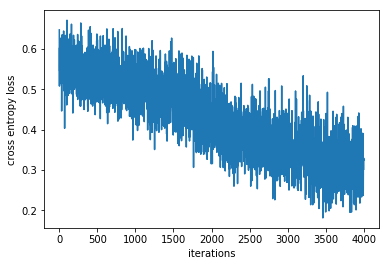

In [12]:
plt.plot(range(len(loss_list)),loss_list)
plt.xlabel("iterations")
plt.ylabel("cross entropy loss")


Text(0,0.5,'Accuracy')

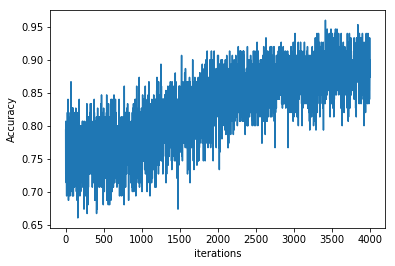

In [13]:
plt.plot(range(len(acc_list)),acc_list)
plt.xlabel("iterations")
plt.ylabel("Accuracy")

### Test accuracy on WEIZMANN

In [15]:
print(np.mean(acc_test_list_weizmann))


0.87096775
